In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import time
# from concurrent.futures import ProcessPoolExecutor

from common.log import *
from common.config import Config
from spider.spider_nasdaq import Spider_nasdaq

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from pandas_highcharts.core import serialize
from pandas_highcharts.display import display_charts

CONF = Config().data[0]
MONGODB = CONF['MONGODB']
NASDAQ = CONF['NASDAQ']
CRYPTOCURRENCY = CONF['CRYPTOCURRENCY']
NASDAQ100 = CONF['NASDAQ100']

pd

<module 'pandas' from 'd:\\python3\\lib\\site-packages\\pandas\\__init__.py'>

In [2]:
%%time

spider = Spider_nasdaq()
timeframe = '10y'
ignore = True

# for symbol in NASDAQ100:
for symbol in ['NDX', 'TSLA']:
#     if symbol == 'SHPG':
#         ignore = False
#     if ignore:
#         continue
#     datafile = spider.get_stock_data(symbol, timeframe)
#     print(datafile)
    pass

Wall time: 0 ns


In [3]:
%%time

### 时间设置
start_date = '2008-06-02'
# start_date = '2010-01-01'
# start_date = '2017-01-03'
# start_date = '2018-01-01'
end_date = '2018-06-06'

### Turtle
TURTLE_POS = 20
TURTLE_BUY_N = 20
TURTLE_SELL_N = 10

### 业务设置
is_happy_money = False
START_MONEY = 100000
HAPPY_MONEY = 0
PROPERTY = START_MONEY
CASH = START_MONEY

Wall time: 0 ns


In [4]:
%%time

stock_df_dict = {}

for symbol in NASDAQ100[:]:
    stock_data_file = '../database/market/%s.csv' % symbol
    stock_df = pd.read_csv(stock_data_file)

    # 筛选字段
#     stock_df = stock_df.loc[:, ['date', 'open', 'close']]

    # 去掉Nasdaq行情首行的当天行情
    if symbol in NASDAQ:
        stock_df = stock_df.drop([0])

    # 抛弃空值异常值
    stock_df.dropna(axis=0, how='any', inplace=True)

    # 格式化日期
    # 1.48 s ± 45.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = stock_df['date'].apply(lambda x: pd.Period(x, freq='D'))

    # 445 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
    stock_df = stock_df.assign(date=pd.to_datetime(stock_df['date']))  # need .index.to_period('D')

    # 476 ms ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#     stock_df['date'] = pd.to_datetime(stock_df['date'])  # need .index.to_period('D')
    
    # 转换字段格式
#     stock_df = stock_df.astype(dtype={'volume': 'float64'})

    # 用日期作索引，日期升序排序
    # 95.1 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
    stock_df = stock_df[::-1]
    
    # 407 µs ± 5.07 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     %timeit stock_df.set_index(['date'], inplace=False)

    # Wall time: 500 µs
    stock_df.set_index(['date'], inplace=True)
    
    # 305 µs ± 2.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#     stock_df = stock_df.sort_index(axis=0, ascending=True)
    
    # 822 µs ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    stock_df.index = stock_df.index.to_period('D')

    # 计算涨跌幅
#     stock_df['c_pct_chg'] = stock_df.close.pct_change(1)
    stock_df['o_pct_chg'] = stock_df.open.pct_change(1)
    
    # Turtle指标
    stock_df['TR1'] = abs(stock_df['high'] - stock_df['low'])
    stock_df['TR2'] = abs(stock_df['high'] - stock_df['close'].shift())
    stock_df['TR3'] = abs(stock_df['low'] - stock_df['close'].shift())
    stock_df['TR'] = stock_df[['TR1', 'TR2', 'TR3']].max(axis=1)
    stock_df['N'] = stock_df['TR'].rolling(20).mean()
    stock_df['Unit'] = (0.01 * START_MONEY) / (stock_df['N'])
#     stock_df['rolling_%d_max' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).max()
#     stock_df['rolling_%d_min' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).min()
    stock_df['rolling_max'] = stock_df['open'].rolling(TURTLE_BUY_N).max()
    stock_df['rolling_min'] = stock_df['open'].rolling(TURTLE_SELL_N).min()
    stock_df['MA%d' % TURTLE_BUY_N] = stock_df['open'].rolling(TURTLE_BUY_N).mean()
    stock_df['MA%d' % TURTLE_SELL_N] = stock_df['open'].rolling(TURTLE_SELL_N).mean()
    stock_df['EWMA'] = stock_df['open'].ewm(alpha=0.1, adjust=False).mean()
    stock_df['MA350'] = stock_df['open'].rolling(350).mean()
    stock_df['MA25'] = stock_df['open'].rolling(25).mean()
    
#     stock_df['ops'] = ''
#     stock_df['profit'] = 0
    
    # 减少数据
    # stock_df = stock_df['2016-01-01':]
    stock_df.dropna(how='any', inplace=True)
    stock_df.drop(columns=['volume', 'TR1', 'TR2', 'TR3'], inplace=True)
    
    stock_df_dict[symbol] = stock_df
    
#     print(stock_df.head(10))
#     print(stock_df.dtypes)
#     print(stock_df.index[0])
#     print(type(stock_df.index[0]))

Wall time: 49.4 s


In [5]:
# %matplotlib inline

# import matplotlib
# import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = [30, 20]

df = stock_df_dict['HAS'].iloc[0:800].copy()
# df
# # df[(df.open == df.rolling_60_max)]
# # df[(df.open >= df.rolling_60_max) & (df.MA30 > df.MA60)]
# # df[(df.MA30 > df.MA60)]

# df = df.loc[:, ['open', 'rolling_60_max', 'rolling_30_min', 'MA60', 'MA30']]

df.reset_index(drop=False, inplace=True)
df = df.astype(dtype={'date': 'datetime64[ns]'})
df.set_index('date', inplace=True)
# df.index.astype()

# from pandas.compat import StringIO
# data = """Date,Value\n2019-12-31,1.7\n2018-12-31,1.7\n2017-12-31,1.7\n2016-12-31,1.5\n2015-12-31,1.247\n2014-12-31,0.896\n2013-12-31,1.601\n2012-12-31,2.13\n2011-12-31,2.498\n2010-12-31,1.158\n2009-12-31,0.226\n2008-12-31,2.738\n2007-12-31,2.285\n2006-12-31,1.784\n2005-12-31,1.92\n2004-12-31,1.799\n2003-12-31,1.022\n2002-12-31,1.346\n2001-12-31,1.904\n2000-12-31,1.418\n1999-12-31,0.626\n1998-12-31,0.593\n1997-12-31,1.542\n1996-12-31,1.19\n1995-12-31,1.733\n1994-12-31,2.717\n1993-12-31,4.476\n1992-12-31,5.046\n1991-12-31,3.474\n1990-12-31,2.687\n1989-12-31,2.778\n1988-12-31,1.274\n1987-12-31,0.242\n1986-12-31,-0.125\n1985-12-31,2.084\n1984-12-31,2.396\n1983-12-31,3.284\n1982-12-31,5.256\n1981-12-31,6.324\n1980-12-31,5.447\n"""
# df = pd.read_csv(StringIO(data), index_col=0, parse_dates=True)
# # df
# df.index

# display_charts(df, chart_type='stock', kind='line', y=['open', 'rolling_max', 'rolling_min'], figsize=(900, 600), logy=False)

# display_charts(df)
# ax = df.plot(kind='line', y=['open', 'rolling_max', 'rolling_min'], label='', linewidth=1)

for symbol in NASDAQ100:
    tdf = stock_df_dict[symbol]
    buy_sig = tdf[(stock_df_dict[symbol].open == stock_df_dict[symbol].rolling_max)]
    buy_sig2 = buy_sig[buy_sig.MA25 >= buy_sig.MA350]
#     print(symbol, len(tdf), len(buy_sig), len(buy_sig2))

In [6]:
%%time

show_df = None
show_df = stock_df_dict['NDX'].copy()

Wall time: 499 µs


In [7]:
%%time
# %xmode

PROPERTY = START_MONEY
CASH = START_MONEY

order_df = None
order_df = pd.DataFrame(columns=[
    'buy_date', 'symbol', 'buy_count', 'buy_price', 'buy_reason', 'sell_date', 'sell_price', 'sell_reason', 'profit', 'cash', 'property'
])
count_day = 0
yesterday = None

# rolling_min_dict = {}
# rolling_max_dict = {}

# for symbol in NASDAQ100:
#     rolling_min_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_SELL_N).min()
#     rolling_max_dict[symbol] = stock_df_dict[symbol].loc[:, 'open'].rolling(TURTLE_BUY_N).max()
    

for today in pd.period_range(start=start_date, end=end_date, freq='D'):
# for today in pd.period_range(start='2018-01-03', end='2018-01-04', freq='D'):
    count_day += 1
    
    if yesterday is None:
        yesterday = today
        continue

    if today not in stock_df_dict['NDX'].index:
        continue

    if is_happy_money:        
        if PROPERTY > START_MONEY * 2:
            HAPPY_MONEY += 50000
            PROPERTY -= 50000
            CASH = PROPERTY
    
    # 买卖过程
    for symbol in NASDAQ100[:]:
#     for symbol in ['TSLA']:
        if symbol in ['ALGN', 'ROST', 'ORLY', 'ESRX', 'ULTA', 'REGN', 'MNST']:
#             continue
            pass

        if symbol == 'NDX':
            continue
        
        if today not in stock_df_dict[symbol].index or yesterday not in stock_df_dict[symbol].index:
            continue
            
        # TIME TEST
#         print(order_df)
#         print(order_df.columns)
        
#         %timeit (len(order_df[order_df['symbol'] == symbol]) != 0)
#         %timeit order_df[order_df['symbol'] == symbol].shape[0] != 0
#         %timeit n_order_df = order_df.values
#         %timeit len(n_order_df[n_order_df[:, 1] == symbol]) != 0
#         %timeit (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)


#         iiidx = stock_df_dict[symbol].index.get_loc(today)
#         print(iiidx, type(iiidx))
#         %timeit stock_df_dict[symbol].loc[today]
#         %timeit n_stock_df = stock_df_dict[symbol].values
#         %timeit n_stock_df[iiidx]
        
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])



#         %timeit int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#         %timeit int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#         %timeit buy_count * stock_df_dict[symbol].loc[today, 'open']
#         %timeit stock_df_dict[symbol]
#         %timeit stock_df_dict[symbol].loc[today, 'open']
#         %timeit (stock_df_dict[symbol].loc[today, 'open'] > order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N'])
        
        n_order_df = order_df.values
#         n_stock_df = stock_df_dict[symbol].values
#         today_idx = stock_df_dict[symbol].index.get_loc(today)
        is_has_order = (len(n_order_df[n_order_df[:, 1] == symbol]) != 0)
#         is_order_soldout = not is_has_order and (len(n_order_df[n_order_df[:, 6] == symbol]) == 0)
        
#         is_has_order = (len(order_df[order_df['symbol'] == symbol]) != 0)
#         is_order_soldout = (len(order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)]) == 0)
        
        # 突破上行趋势，从未建仓或已清仓，建仓1Unit
        n_order_df = order_df.values
        if not is_has_order or (len( n_order_df[(n_order_df[:, 1] == symbol) & (n_order_df[:, 6] == 0)] ) == 0):
            is_buy = (stock_df_dict[symbol].loc[today, 'open'] >= stock_df_dict[symbol].loc[today, 'rolling_max'])
            is_buy = is_buy and (stock_df_dict[symbol].loc[today, 'MA25'] >= stock_df_dict[symbol].loc[today, 'MA350'])
            if is_buy:
                buy_count = 0
#                 buy_count = min(
#                     int(stock_df_dict[symbol].shift(1).loc[today, 'Unit']),
#                     int(CASH / stock_df_dict[symbol].loc[today, 'open'])
#                 )
#                 print(symbol, today)
#                 buy_count = int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#                 buy_count = int(min(PROPERTY / TURTLE_POS, CASH) / stock_df_dict[symbol].loc[today, 'open'])
                if CASH > START_MONEY / TURTLE_POS:
                    buy_count = int((START_MONEY / TURTLE_POS) / stock_df_dict[symbol].loc[today, 'open'])
                if buy_count > int(CASH / stock_df_dict[symbol].loc[today, 'open']):
                    buy_count = 0
#                 buy_count = 1
                if buy_count > 0:
                    CASH -= buy_count * stock_df_dict[symbol].loc[today, 'open']
#                     print(today, '建仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
                    order_df = order_df.append(
                        {
                            'buy_date': today,
                            'symbol': symbol,
                            'buy_count': buy_count,
                            'buy_price': stock_df_dict[symbol].loc[today, 'open'],
                            'buy_reason': 'ENTER',
                            'sell_date': pd.np.nan,
                            'sell_price': 0,
                            'profit': 0,
                            'cash': CASH,
                            'property': PROPERTY,
                        },
                        ignore_index=True
                    )
            
#         # 升幅大于0.5N，加仓1Unit
#         n_order_df = order_df.values
#         if is_has_order and (len( n_order_df[(n_order_df[:, 1] == symbol) & (n_order_df[:, 6] == 0)] != 0 )):
#             is_buy = (
#                 stock_df_dict[symbol].loc[today, 'open'] > \
#                 order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].buy_price.iloc[-1] + \
#                 0.5 * stock_df_dict[symbol].shift(1).loc[today, 'N']
#             )
#             if is_buy:
# #                 buy_count = min(
# #                     int(stock_df_dict[symbol].shift(1).loc[today, 'Unit']),
# #                     int(CASH / stock_df_dict[symbol].loc[today, 'open'])
# #                 )
#                 buy_count = int(stock_df_dict[symbol].shift(1).loc[today, 'Unit'])
#                 if buy_count > int(CASH / stock_df_dict[symbol].loc[today, 'open']):
#                     buy_count = 0
#                 if buy_count > 0:
#                     CASH -= buy_count * stock_df_dict[symbol].loc[today, 'open']
# #                     print(today, '加仓', buy_count, stock_df_dict[symbol].loc[today, 'open'], CASH)
#                     order_df = order_df.append(
#                         {
#                             'buy_date': today,
#                             'symbol': symbol,
#                             'buy_count': buy_count,
#                             'buy_price': stock_df_dict[symbol].loc[today, 'open'],
#                             'buy_reason': 'ADD',
#                             'sell_date': pd.np.nan,
#                             'sell_price': 0,
#                             'profit': 0,
#                             'cash': CASH,
#                             'property': PROPERTY,
#                         },
#                         ignore_index=True
#                     )
        
        # 降幅大于2N，清仓退出
        n_order_df = order_df.values
        if is_has_order and (len( n_order_df[(n_order_df[:, 1] == symbol) & (n_order_df[:, 6] == 0)] != 0 )):
            is_sell = (
                stock_df_dict[symbol].loc[today, 'open'] < \
                order_df[order_df['symbol'] == symbol].buy_price.iloc[-1] - 2 * stock_df_dict[symbol].shift(1).loc[today, 'N']
            )
            if is_sell:
                for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                    CASH += order_df.loc[idx, 'buy_count'] * stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_reason'] = 'LOSS'
                    order_df.loc[idx, 'profit'] = \
                        (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
#                 print(today, '止损', stock_df_dict[symbol].loc[today, 'open'], CASH)
        
        # 突破下行趋势，清仓退出
        n_order_df = order_df.values
        if is_has_order and (len( n_order_df[(n_order_df[:, 1] == symbol) & (n_order_df[:, 6] == 0)] != 0 )):
            is_sell = (stock_df_dict[symbol].loc[today, 'open'] <= stock_df_dict[symbol].loc[today, 'rolling_min'])
            if is_sell:
                for idx in order_df[(order_df['symbol'] == symbol) & (order_df['sell_price'] == 0)].index:
                    CASH += order_df.loc[idx, 'buy_count'] * stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_date'] = today
                    order_df.loc[idx, 'sell_price'] = stock_df_dict[symbol].loc[today, 'open']
                    order_df.loc[idx, 'sell_reason'] = 'EXIT'
                    order_df.loc[idx, 'profit'] = \
                        (order_df.loc[idx, 'sell_price'] - order_df.loc[idx, 'buy_price']) * order_df.loc[idx, 'buy_count']
#                 print(today, '退出', stock_df_dict[symbol].loc[today, 'open'], CASH)
    
    # 每天盘点财产
    show_df.loc[today, 'CASH_TURTLE'] = CASH
    PROPERTY = CASH + \
        sum(
            [
                stock_df_dict[order_df.loc[idx, 'symbol']].loc[today, 'open'] * order_df.loc[idx, 'buy_count'] \
                for idx in order_df.loc[order_df['sell_price']==0].index
            ]
        )
    show_df.loc[today, 'PROPERTY_TURTLE'] = PROPERTY

    yesterday = today
            

print(CASH)
print(HAPPY_MONEY)
print(PROPERTY)

s_p = stock_df_dict['NDX'][start_date:].iloc[0].open
e_p = stock_df_dict['NDX'].iloc[-1].open
print('NDX', s_p, e_p, e_p / s_p)


1021.0004
0
218267.5176
NDX 1756.5 7212.431 4.10613777398
Wall time: 14min 38s


In [8]:
# 165 * 220
# 25197.25 / 228.97

# buy_count = min(
#                     int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit']),
#                     int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
#                 )
# int(stock_df_dict['TSLA'].loc['2017-09-18', 'Unit'])
# int(16100.17 / stock_df_dict['TSLA'].loc['2017-09-19', 'open'])
# buy_count

# pd.reset_option("display.max_rows")
# order_df

# order_df[(order_df['symbol'] == 'TSLA') & (order_df['sell_price'] == 0)]
# pd.options.display.max_rows = 999
# stock_df_dict['TSLA'].loc[start_date:]

In [9]:
'ALL'
'len(order_df)', len(order_df)
sum_profit = sum(list(order_df['profit']))
'sum_profit', sum_profit
# sum_tax = sum(list(order_df_TB['tax']))
sum_tax = 0
'sum_tax', sum_tax
'win rate', len(order_df[order_df.profit > 0]) / len(order_df[order_df.profit != 0])
'REWARD', ((sum_profit - sum_tax) / START_MONEY + 1) ** (365 / count_day)
len(order_df[order_df.profit != 0])
len(order_df[order_df.profit > 0])
len(order_df[order_df.sell_reason == 'EXIT'])
len(order_df[(order_df.sell_reason == 'EXIT') & (order_df.profit > 0)])
sum(list(order_df[order_df.sell_reason == 'EXIT']['profit']))
len(order_df[order_df.sell_reason == 'LOSS'])
len(order_df[(order_df.sell_reason == 'LOSS') & (order_df.profit > 0)])
sum(list(order_df[order_df.sell_reason == 'LOSS']['profit']))

# order_df
# order_df.loc[order_df['sell_price']==0]

calc_df = order_df.copy()
calc_df['profit_pct'] = calc_df['profit'] / (calc_df['buy_count'] * calc_df['buy_price'])
# calc_df[calc_df.symbol == 'BIDU']
# calc_df[calc_df.profit > 0]
calc_df

# order_df[order_df.profit > 0]

# csv_file = 'E:/Dev/result/T_TURTLE_POS%d_TURTLE_BUY_N%d_TURTLE_SELL_N%d_START_MONEY%d_%s_%s.csv' % \
#     (TURTLE_POS, TURTLE_BUY_N, TURTLE_SELL_N, START_MONEY, start_date, end_date)
# calc_df.to_csv(csv_file)

'ALL'

('len(order_df)', 3215)

('sum_profit', 107378.10040000011)

('sum_tax', 0)

('win rate', 0.4096651926721415)

('REWARD', 1.075512980806395)

3166

1297

2588

1297

279083.32250000065

585

0

-171705.22209999996

,buy_date,symbol,buy_count,buy_price,buy_reason,sell_date,sell_price,sell_reason,profit,cash,property,profit_pct
0,2009-10-27,AMZN,40,122.9300,ENTER,2009-12-15,130.76,EXIT,313.2,95082.8000,100000,0.0636948
1,2009-10-27,BKNG,27,179.8500,ENTER,2009-10-28,170.51,LOSS,-252.18,90226.8500,100000,-0.0519322
2,2009-10-27,EXPE,191,26.1170,ENTER,2009-10-30,23.7552,LOSS,-451.104,85238.5030,100000,-0.0904315
3,2009-10-27,INTU,166,30.0700,ENTER,2009-11-02,28.97,EXIT,-182.6,80246.8830,100000,-0.0365813
4,2009-10-27,PAYX,170,29.2500,ENTER,2009-11-03,28.43,EXIT,-139.4,75274.3830,100000,-0.0280342
5,2009-10-30,ORLY,133,37.5600,ENTER,2009-11-20,38.65,EXIT,144.97,79419.9162,99538,0.0290202
6,2009-10-30,SHPG,94,53.0400,ENTER,2009-11-20,56.16,EXIT,293.28,74434.1562,99538,0.0588235
7,2009-10-30,SYMC,283,17.6600,ENTER,2009-12-08,17.32,EXIT,-96.22,69436.3762,99538,-0.0192525
8,2009-11-02,VRTX,134,37.1300,ENTER,2009-11-20,38.7,EXIT,210.38,69269.9762,99095.3,0.0422839
9,2009-11-03,CTSH,240,20.8250,ENTER,2009-11-27,21.75,EXIT,222,64271.9762,98698.9,0.0444178


In [10]:
bad_stock_cnt = 0
for symbol, stock_df in stock_df_dict.items():
    df = stock_df.loc[start_date:end_date, 'close']
#     print(df)
    s_p = df.head(1).values
    e_p = df.tail(1).values
#     print(symbol, s_p, e_p, e_p / s_p)
    if e_p / s_p < 3.89704671:
        bad_stock_cnt += 1
bad_stock_cnt


50

In [11]:
%matplotlib inline

import sys
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# order_df_TB
bar_df = order_df.copy()
df = bar_df.sort_values(by=['profit'])
# df

bins = [100 * x for x in range(-200, 500)]
# bins

cats = pd.cut(df['profit'], bins)
# cats

def get_stats(group):
    return {'count': group.count()}

grouped = df['profit'].groupby(cats)
bin_counts = grouped.apply(get_stats).unstack()
bin_counts.reset_index(inplace=True, drop=False)
bin_counts['profit'] = bin_counts['profit'].apply(str)
# bin_counts

# df['profit'].hist(bins=10)

# bin_counts.plot(kind='barh', alpha=0.5, rot=0)

# display_charts(bin_counts, kind='bar', x='profit', figsize=(900, 600), logy=True)

d:\python3\lib\site-packages\pandas\plotting\_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


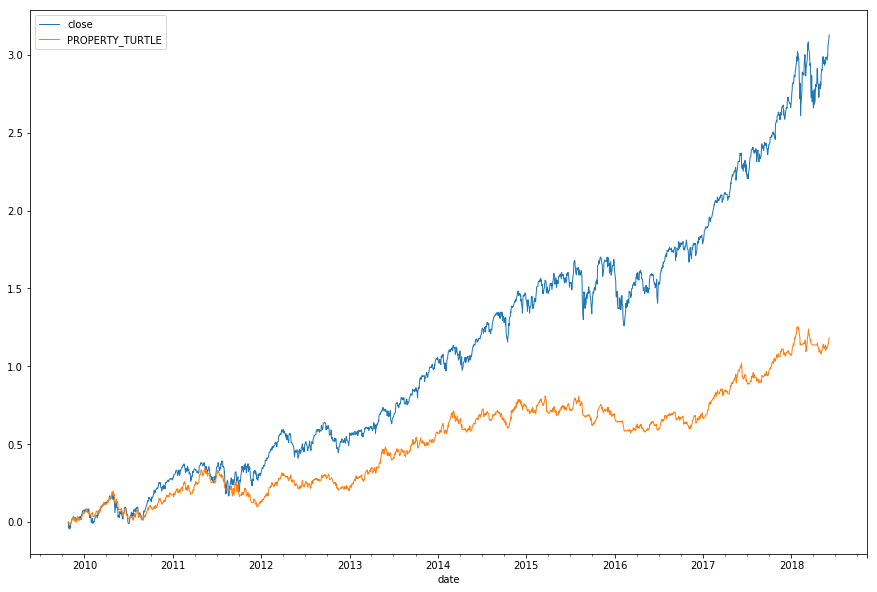

In [12]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

df = show_df.dropna(how='any', inplace=False).copy()

# fc = df.iloc[0]['close']
# df.loc[:, ['close']]

df['close'] = (df['close'] - df.iloc[0]['close']) / df.iloc[0]['close']
df['PROPERTY_TURTLE'] = (df['PROPERTY_TURTLE'] - df.iloc[0]['PROPERTY_TURTLE']) / df.iloc[0]['PROPERTY_TURTLE']
# df['S'] = (stock_df_dict['BIDU'].open - stock_df_dict['BIDU'].iloc[0].open) / stock_df_dict['BIDU'].iloc[0].open
# df['PROPERTY_T+B'] = (df['PROPERTY_T+B'] - df.iloc[0]['PROPERTY_T+B']) / df.iloc[0]['PROPERTY_T+B']

ax = df.plot(kind='line', y=['close', 'PROPERTY_TURTLE'], linewidth=1)
# ax = df.plot(kind='line', y='close', label='NDX', linewidth=1)
# ax = df.plot(kind='line', y='PROPERTY_TURTLE', secondary_y=False, label='PROPERTY_TURTLE', linewidth=1, ax=ax)
# ax = df.plot(kind='line', y='PROPERTY_T+B', secondary_y=False, label='PROPERTY_T+B', linewidth=1, ax=ax)

# for symbol, stock_df in stock_df_dict.items():
#     df = stock_df.copy()
#     df['close'] = (df['close'] - df.head(1)['close'].values) / df.head(1)['close'].values
#     ax = df.plot(kind='line', y='close', secondary_y=False, label=symbol, linewidth=0.5, ax=ax)

# plt.figure(figsize=(10, 6), dpi=80)
# plt.show()

# df = df.loc[:, ['close', 'PROPERTY_TURTLE', 'PROPERTY_T+B']]
# df
# display_charts(df, kind='line', figsize=(900, 600), logy=False)